I am analysing the cencesus income dataset. The source of the dataset is UCI.
data_source = "https://archive.ics.uci.edu/ml/datasets/census+income"
The outcome of the dataset is a binary classification that is population having income less or equal 50k and population having more than 50k. There are 13 feature which determine the income. We will see who are the lower-income and the higher-income.

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn import metrics
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import warnings 
warnings.filterwarnings("ignore")

# DATA MINING

In [2]:
data=pd.read_csv('adult.csv', header=None)


In [3]:
data.shape

(32561, 15)

In [4]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Data CLEANING

#### Rename columns

In [5]:
data = data.rename(columns={0:"age", 1:"workclass",2:"id", 3:"education", 4:"education_num",
                5:"marital_status", 6:"occupation", 7:"relationship",
                    8:"race",9:"sex", 10:"capital_gain", 11:"capital_loss", 12:"hours_per_week",13:"native_country", 14:"income"})

In [6]:
data.head(3)

,age,workclass,id,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


#### Check for duplicate records

In [7]:
data.duplicated().sum()

24

In [8]:
#Filtering out the duplicate rows
duplicate = data[data.duplicated()]

In [9]:
# drop duplicate rows
data = data.drop_duplicates()

In [10]:
# education_num is correlated with education, so we drop education_num
#  drop column id and education_num.
cols_to_drop = ['id', 'education_num']
data = data.drop(cols_to_drop, axis=1)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32537 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32537 non-null  int64 
 1   workclass       32537 non-null  object
 2   education       32537 non-null  object
 3   marital_status  32537 non-null  object
 4   occupation      32537 non-null  object
 5   relationship    32537 non-null  object
 6   race            32537 non-null  object
 7   sex             32537 non-null  object
 8   capital_gain    32537 non-null  int64 
 9   capital_loss    32537 non-null  int64 
 10  hours_per_week  32537 non-null  int64 
 11  native_country  32537 non-null  object
 12  income          32537 non-null  object
dtypes: int64(4), object(9)
memory usage: 3.5+ MB


In [12]:
data.describe()

,age,capital_gain,capital_loss,hours_per_week
count,32537.000000,32537.000000,32537.000000,32537.000000
mean,38.585549,1078.443741,87.368227,40.440329
std,13.637984,7387.957424,403.101833,12.346889
min,17.000000,0.000000,0.000000,1.000000
25%,28.000000,0.000000,0.000000,40.000000
50%,37.000000,0.000000,0.000000,40.000000
75%,48.000000,0.000000,0.000000,45.000000
max,90.000000,99999.000000,4356.000000,99.000000


#### Remove blank space in the row data cell 

In [13]:
data["income"].unique()

array([' <=50K', ' >50K'], dtype=object)

In [14]:
#remove whitespace from the data
def remove_whitespace(dataframe):
    for i in dataframe.columns:
        if dataframe[i].dtype == 'object':
            dataframe[i] = dataframe[i].map(str.strip)
    



In [15]:
remove_whitespace(data)
    

### Replace "?" into null

In [16]:
data["workclass"].unique()

array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', '?', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [17]:
#replace ? with NaN to make it easier to handle missing values
data.replace("?", np.NaN).isnull().sum()

age                  0
workclass         1836
education            0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     582
income               0
dtype: int64

In [18]:
data = data.replace("?", np.NaN)


### Remove missing data

In [19]:
data.dropna(inplace=True)

#### Check for outlier records

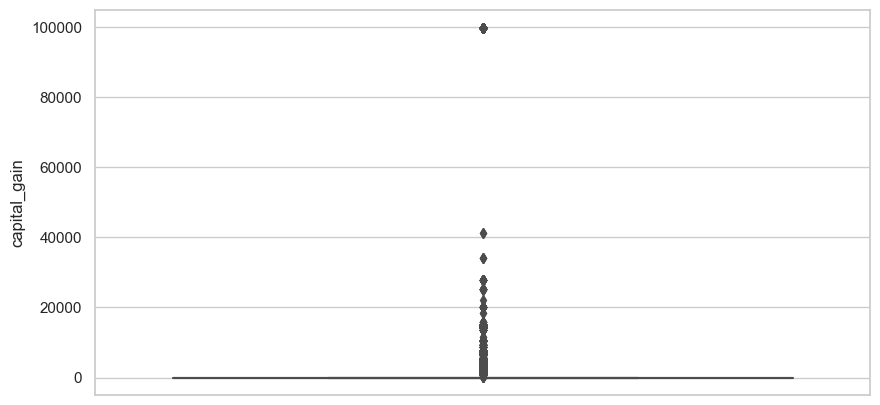

In [20]:
plt.figure(figsize=(10,5))
sns.boxplot(y='capital_gain',data=data)
plt.show()

In [21]:
data['capital_gain'].describe()

count    30139.000000
mean      1092.841202
std       7409.110596
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital_gain, dtype: float64

In [22]:
data[data['capital_gain'] == 99999]

,age,workclass,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
1246,54,Self-emp-inc,Prof-school,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999,0,60,United-States,>50K
1368,52,Private,HS-grad,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,99999,0,40,Japan,>50K
1482,53,Self-emp-inc,HS-grad,Married-civ-spouse,Sales,Husband,White,Male,99999,0,40,United-States,>50K
1528,52,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999,0,50,United-States,>50K
1616,46,Private,Prof-school,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999,0,60,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31111,22,Self-emp-not-inc,Some-college,Never-married,Sales,Own-child,Black,Male,99999,0,55,United-States,>50K
31828,47,Private,Masters,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999,0,55,United-States,>50K
31972,43,Self-emp-inc,Prof-school,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999,0,40,United-States,>50K
32238,47,Private,Prof-school,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999,0,40,United-States,>50K


In [23]:
#remove outliers from capital_gain column using z-score method
standard_deviations = 3
data = data[((data['capital_gain'] - data['capital_gain'].mean()) / data['capital_gain'].std()).abs() < standard_deviations]

In [24]:
data["capital_gain"].describe()

count    29941.000000
mean       558.900638
std       2319.978615
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      22040.000000
Name: capital_gain, dtype: float64

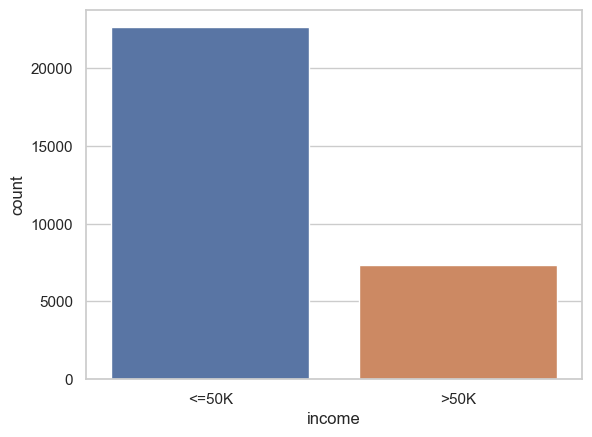

In [25]:
#Count of people with income <=50K and >50K
sns.countplot(x='income',data=data)
plt.show()


In [26]:
#Percentage of people with income <=50K and >50K
count_lessorequal50 = len(data[data['income']=="<=50K"])
count_greaterorequalthan50 = len(data[data['income']==">50K"])
pct_lessorequal50 = count_lessorequal50/(count_lessorequal50 + count_greaterorequalthan50)
print("percentage of population with income less or equal 50k is", pct_lessorequal50*100)
pct_greaterorequalthan50 = count_greaterorequalthan50/(count_lessorequal50 + count_greaterorequalthan50)
print("percentage of population with income greate than 50k is", pct_greaterorequalthan50*100)

percentage of population with income less or equal 50k is 75.57529808623626
percentage of population with income greate than 50k is 24.424701913763734


In [27]:
# mean of numerical columns grouped by income
data.groupby('income').mean().round(2)

,age,capital_gain,capital_loss,hours_per_week
income,,,,
<=50K,36.61,140.89,53.51,39.35
>50K,43.91,1852.31,198.92,45.60


In [28]:
# Calculate the percentage of each category in the categorical columns
def percentage_calculator(dataframe, column):
    data_dic = {}
    for i in dataframe[column].unique():
        count = len(dataframe[dataframe[column]==i])
        percent = round((count/len(dataframe))*100,0)
        if column not in data_dic:
            data_dic[column] = [i]
            data_dic["percent"] = [percent]
        else:
            data_dic[column].append(i)
            data_dic["percent"].append(percent)
    return data_dic

In [29]:
# Classify the data into two groups based on the income
data_lower_income = data[data['income']=="<=50K"]
data_higher_income = data[data['income']==">50K"]


In [30]:
# Calculate the percentage of each category in the column for the whole population
def get_over_all_percentage(column):
    data_dic = percentage_calculator(data, column)
    percentage_over_all_population = pd.DataFrame(data_dic)
    percentage_over_all_population.rename(columns={"percent":"%_over_all_population"}, inplace=True)
    return percentage_over_all_population

In [31]:
# Calculate the percentage of each category in the column for the lower-income population
def get_lower_income_population_percentage(column):
    data_dic = percentage_calculator(data_lower_income, column)
    percentage_lower_income_population = pd.DataFrame(data_dic)
    percentage_lower_income_population.rename(columns={"percent":"%_lower_income_population"}, inplace=True)
    return percentage_lower_income_population

In [32]:
#Calculate the percentage of each category in the column for the higher-income population
def get_higher_income_population_percentage(column):
    data_dic = percentage_calculator(data_higher_income, column)
    percentage_higher_income_population = pd.DataFrame(data_dic)
    percentage_higher_income_population.rename(columns={"percent":"%_higher_income_population"}, inplace=True)
    return percentage_higher_income_population

In [33]:
# # concatenating the dataframes
from functools import reduce
def merge_dataframes(column):
    df1 = get_over_all_percentage(column)
    df2 = get_lower_income_population_percentage(column)
    df3 = get_higher_income_population_percentage(column)
    data_frames = [df1, df2, df3]
    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=[column],
                                        how='outer'), data_frames)
    df_merged.set_index(column, inplace=True)
    return df_merged

In [34]:
merge_dataframes("race")

,%_over_all_population,%_lower_income_population,%_higher_income_population
race,,,
White,86.0,84.0,91.0
Black,9.0,11.0,5.0
Asian-Pac-Islander,3.0,3.0,3.0
Amer-Indian-Eskimo,1.0,1.0,0.0
Other,1.0,1.0,0.0


In [35]:
def get_categorical_variables(dataframe):
    categorical_variables = []
    for i in dataframe.columns:
        if dataframe[i].dtype == 'object':
            categorical_variables.append(i)
    return categorical_variables

In [36]:
def get_numerical_variables(dataframe):
    numerical_variables = []
    for i in dataframe.columns:
        if dataframe[i].dtype != 'object':
            numerical_variables.append(i)
    return numerical_variables
    
    

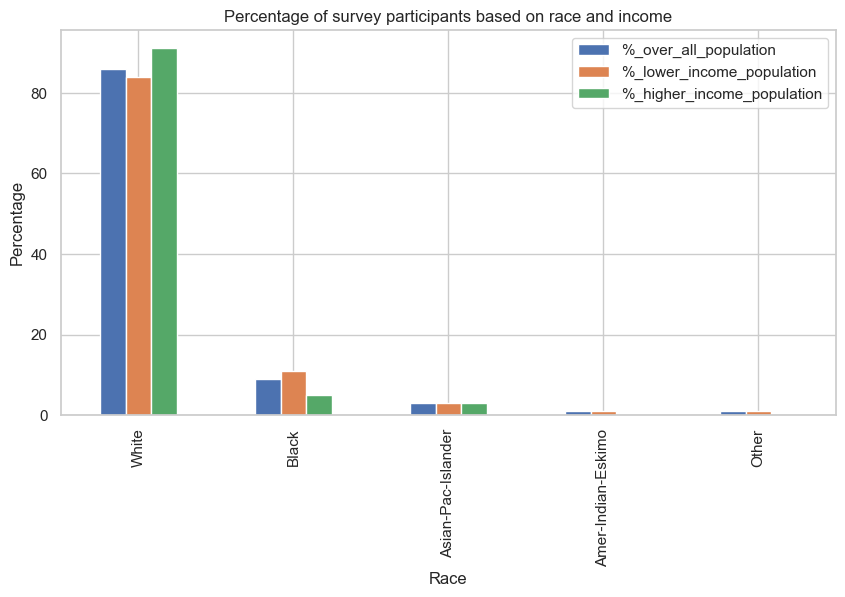

In [37]:
merge_dataframes("race").plot(kind='bar', figsize=(10,5))
plt.title("Percentage of survey participants based on race and income")
plt.ylabel("Percentage")
plt.xlabel("Race")
plt.show()

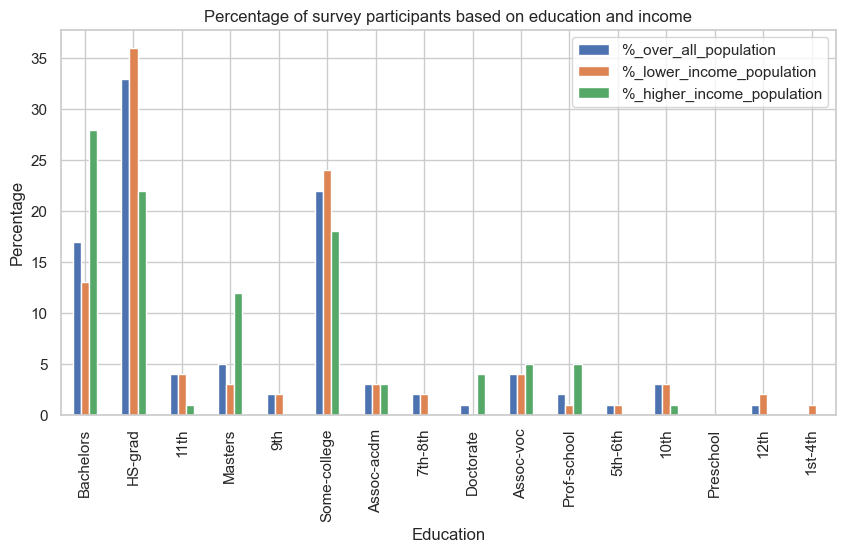

In [38]:

merge_dataframes("education").plot(kind='bar', figsize=(10,5))
plt.title("Percentage of survey participants based on education and income")
plt.ylabel("Percentage")
plt.xlabel("Education")
plt.show()

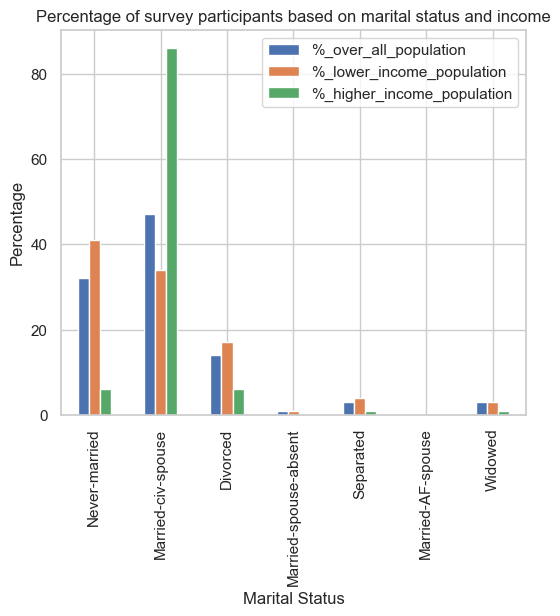

In [39]:
merge_dataframes("marital_status").plot(kind='bar', figsize=(6,5))
plt.title("Percentage of survey participants based on marital status and income")
plt.ylabel("Percentage")
plt.xlabel("Marital Status")
plt.show()

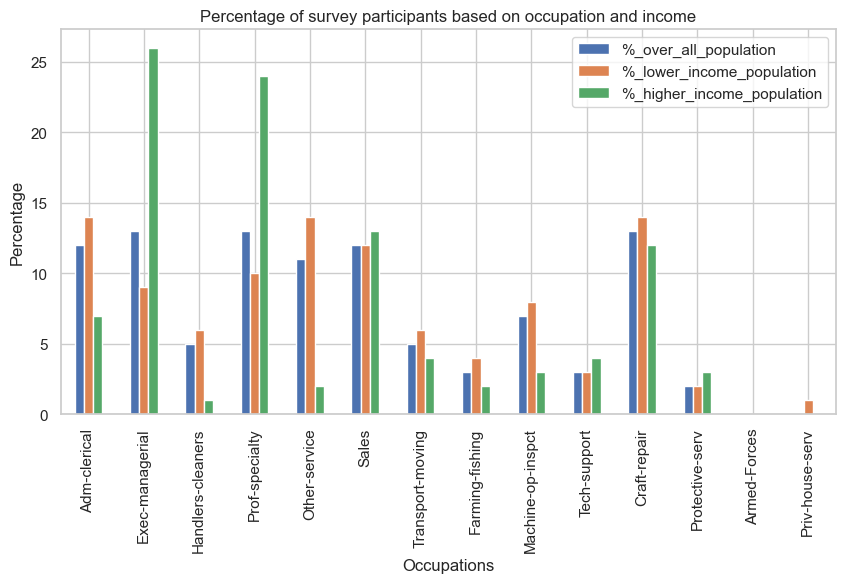

In [40]:
merge_dataframes("occupation").plot(kind='bar', figsize=(10,5))
plt.title("Percentage of survey participants based on occupation and income")
plt.ylabel("Percentage")
plt.xlabel("Occupations")
plt.show()

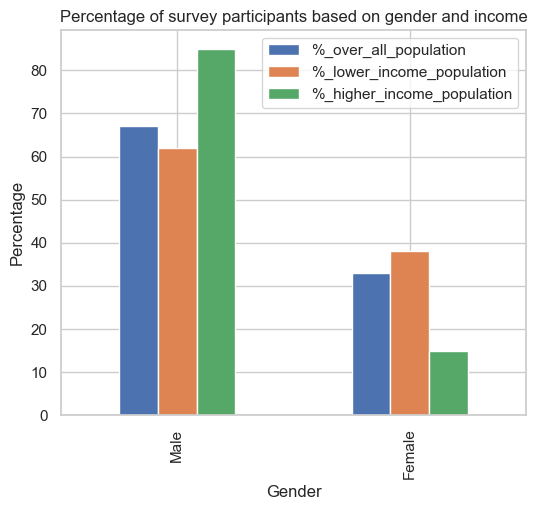

In [41]:
merge_dataframes("sex").plot(kind='bar', figsize=(6,5))
plt.title("Percentage of survey participants based on gender and income")
plt.ylabel("Percentage")
plt.xlabel("Gender")
plt.show()

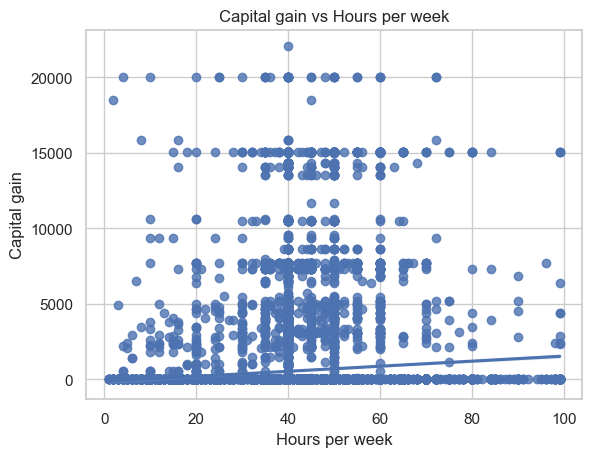

In [42]:

sns.regplot(x="hours_per_week", y="capital_gain", data=data)
plt.title("Capital gain vs Hours per week")
plt.ylabel("Capital gain")
plt.xlabel("Hours per week")
plt.show()

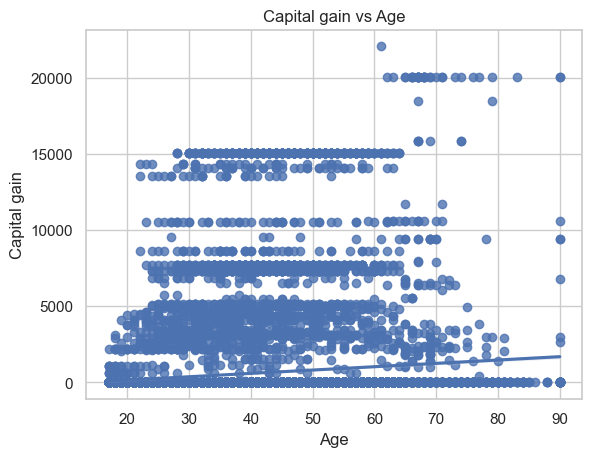

In [43]:
sns.regplot(x="age", y="capital_gain", data=data)
plt.title("Capital gain vs Age")
plt.ylabel("Capital gain")
plt.xlabel("Age")
plt.show()


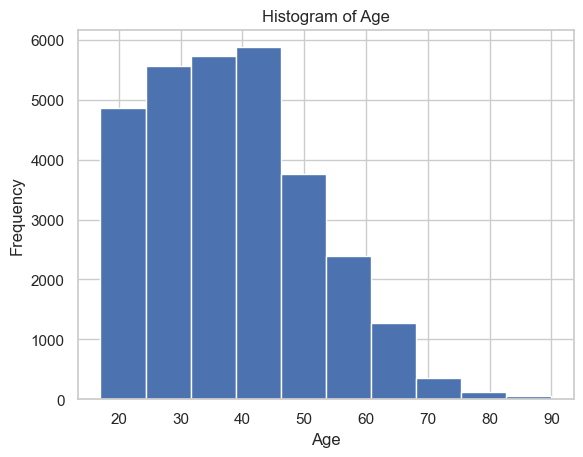

In [44]:
data.age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [45]:
data.corr()

,age,capital_gain,capital_loss,hours_per_week
age,1.000000,0.124115,0.061165,0.099705
capital_gain,0.124115,1.000000,-0.052863,0.086367
capital_loss,0.061165,-0.052863,1.000000,0.053659
hours_per_week,0.099705,0.086367,0.053659,1.000000


<AxesSubplot: >

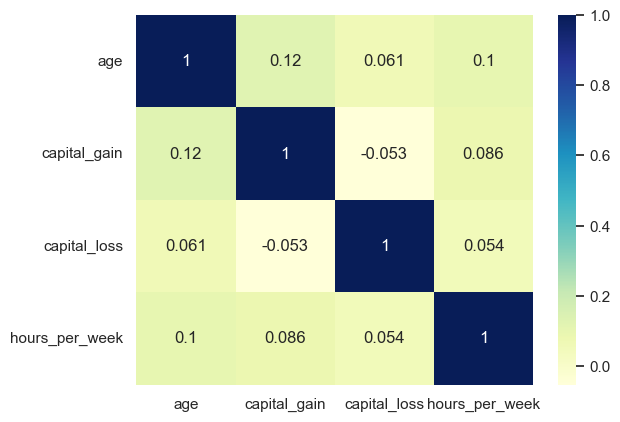

In [46]:
sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)

#### Save data in csv format

In [47]:
data.to_csv('adult_cleaned.csv', index=False)

## Create dummy variables

In [48]:
clean_data = pd.read_csv('adult_cleaned.csv')

Set income value "<=50k" into 1 and ">50k" into 0


In [49]:
clean_data["income"]= clean_data["income"].map({"<=50K":1, ">50K":0})

In [50]:
categorical_vars = get_categorical_variables(clean_data)
categorical_vars

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country']

In [51]:
#Create dummy variables for categorical variables
for var in categorical_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(clean_data[var], prefix=var)
    clean_data_dumy=clean_data.join(cat_list)
    clean_data=clean_data_dumy
data_vars=clean_data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in categorical_vars]
    


In [52]:
data_final=clean_data[to_keep]


In [53]:
data_final.shape

(29941, 103)

In [54]:
data_final.shape

(29941, 103)

In [55]:
#Remove missing values
data_final.dropna(inplace=True)

### Model setting

In [56]:
# Split into outcome and predictors
x = data_final.drop('income', axis=1)
y = data_final['income']

In [57]:
# Split into train and test and then oversample the training data

os = SMOTE(random_state=0)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
columns = x_train.columns
os_data_X,os_data_y=os.fit_resample(x_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['income'])
print("length of oversampled data is ",len(os_data_X))
print("Number of higher income in oversampled data",len(os_data_y[os_data_y['income']==0]))
print("Number of lower income data",len(os_data_y[os_data_y['income']==1]))
print("Proportion of higher income data in oversampled data is ",len(os_data_y[os_data_y['income']==0])/len(os_data_X))
print("Proportion of lower income data in oversampled data is ",len(os_data_y[os_data_y['income']==1])/len(os_data_X))


length of oversampled data is  31630
Number of higher income in oversampled data 15815
Number of lower income data 15815
Proportion of higher income data in oversampled data is  0.5
Proportion of lower income data in oversampled data is  0.5


In [58]:
logreg = LogisticRegression(random_state=16,solver='lbfgs', max_iter=300)

In [59]:
# fit the model with data
logreg.fit(x_train, y_train)

LogisticRegression(max_iter=300, random_state=16)

In [60]:
y_pred = logreg.predict(x_test)

In [61]:
y_pred 

array([0, 1, 1, ..., 0, 1, 0])

In [62]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[1284  886]
 [ 498 6315]]


In [63]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.59      0.65      2170
           1       0.88      0.93      0.90      6813

    accuracy                           0.85      8983
   macro avg       0.80      0.76      0.78      8983
weighted avg       0.84      0.85      0.84      8983



#### The mode is 85% accurate in predicting the income of the survey participants.

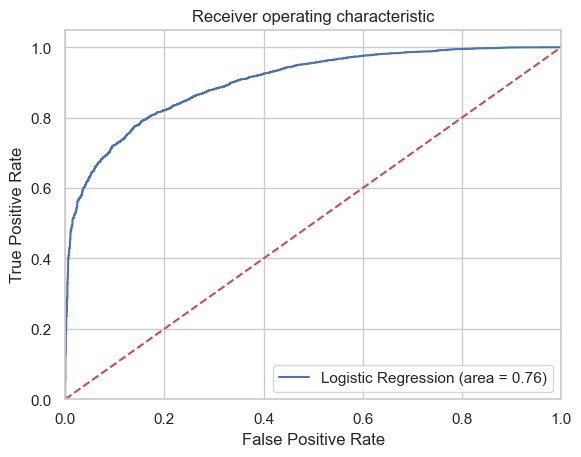

In [64]:
from sklearn.metrics import roc_auc_score, roc_curve
y_pred_proba = logreg.predict_proba(x_test)[::,1]
logit_roc_auc = roc_auc_score(y_test, logreg.predict(x_test))
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
